#### Notebook Contents:
- Import Python Notebooks
- Import DataFrame from Data Extraction Jupyter Notebook
- Data Cleaning and Aggregation
- Modeling

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### Imports

In [1]:
# API 
import praw

# Data Manipulation
import pandas as pd
import numpy as np

# Tokenization
from nltk.tokenize import RegexpTokenizer

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# DateTime
import time

# Web Scrapping, Text Cleaning
from bs4 import BeautifulSoup 

# Stop-Word list
from nltk.corpus import stopwords

# Detect Patterns in Text
import regex as re

# Instantiate stemmer.
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Train Test Split
from sklearn.model_selection import train_test_split

# Count Vectorizor
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

%matplotlib inline

In [2]:
# Set Pandas to view all rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### DataFrame Transfer

In [3]:
# Import master DataFrame from 'Project 3 - Data Extraction'
%store -r master_extract_1
master = master_extract_1

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Data Cleaning and Basic Inspection

#### Basic Checks

In [4]:
# Convert column from Unix time to DateTime
master['Date Created'] = pd.to_datetime(master['Date Created'], unit = 's')

In [5]:
# Checking for Null Values
master.isnull().sum()

ID                    0
Title                 0
Upvotes               0
Downvotes             0
Subreddit             0
Body                  0
URL                   0
Number of Comments    0
Date Created          0
dtype: int64

In [6]:
# Verifying that Column Types are correct
master.dtypes

ID                            object
Title                         object
Upvotes                        int64
Downvotes                      int64
Subreddit                     object
Body                          object
URL                           object
Number of Comments             int64
Date Created          datetime64[ns]
dtype: object

#### Text Cleaning

In [7]:
def text_cleaning(text):
    # Function to convert text to a string of words
    # The input is a single string (ie. Body of reddit post), and the output is a single string
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(text, 'lxml').get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [8]:
# Get the number of reviews based on the dataframe size.
total_posts = master.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean reviews.
clean_title_posts = []
clean_body_posts = []

There are 20 posts.


In [9]:
# Converts everything in master['Title'] into a cleaned version of the text

print("Cleaning Titles of reddit posts...")

t = 0

for title in master['Title']:
    # Convert title to words, then append to clean_title_posts.
    clean_title_posts.append(text_cleaning(title))
    
    # If the index is divisible by 100, print a message
    if (t + 1) % 100 == 0:
        print(f'Review {t + 1} of {total_posts}.')
    
    t += 1

# Converts everything in master['Body'] into a cleaned version of the text

print("Cleaning Body of reddit posts...")

b = 0

for body in master['Body']:
    # Convert review to words, then append to clean_body_posts.
    clean_body_posts.append(text_cleaning(body))

    # If the index is divisible by 100, print a message
    if (b + 1) % 100 == 0:
        print(f'Review {b + 1} of {total_posts}.')
    
    b += 1

Cleaning Titles of reddit posts...
Cleaning Body of reddit posts...


#### DataFrame Aggregation

In [10]:
master.head()

,ID,Title,Upvotes,Downvotes,Subreddit,Body,URL,Number of Comments,Date Created
0,en1us5,Shadow banned !!😡,0,0,FOXNEWS,So lately every time I try to post on Foxnews....,https://www.reddit.com/r/FOXNEWS/comments/en1u...,3,2020-01-11 11:05:14
1,ekw19z,Train wreck,3,0,FOXNEWS,The whole crew at Fox probably has a bad case ...,https://www.reddit.com/r/FOXNEWS/comments/ekw1...,10,2020-01-07 00:03:26
2,ekuwee,Why did you flip the Epstein images?,1,0,FOXNEWS,After watching the 60 minutes broadcast last n...,https://www.reddit.com/r/FOXNEWS/comments/ekuw...,3,2020-01-06 22:34:51
3,egdoxi,What’s the name of this dude?,0,0,FOXNEWS,,https://i.redd.it/v1lwq0jtj7741.jpg,5,2019-12-28 01:05:45
4,eg164t,How can I watch fox news broadcast in Europe (...,0,0,FOXNEWS,My dad has an interest of my chrome cast and t...,https://www.reddit.com/r/FOXNEWS/comments/eg16...,18,2019-12-27 05:21:08


In [11]:
# Converting cleaned posts into DataFrame
clean_title_posts_df = pd.DataFrame(clean_title_posts)
clean_body_posts_df = pd.DataFrame(clean_body_posts)

# Assigning Column Names
clean_title_posts_df.columns = ['Title Cleaned Text']
clean_body_posts_df.columns = ['Body Cleaned Text']

# Combining cleaned posts DataFrames with master DataFrame
master = pd.concat([master, clean_title_posts_df, clean_body_posts_df], axis = 1)

In [12]:
master['Aggregate Cleaned Text'] = master['Title Cleaned Text'] + ' ' + master['Body Cleaned Text']

In [13]:
# Creating a new column where Subreddit strings are replaced by 1's and 0's
master['Subreddit Code'] = master['Subreddit'].apply(lambda x: 1 if x == 'FOXNEWS' else 0)

In [14]:
master.head(2)

,ID,Title,Upvotes,Downvotes,Subreddit,Body,URL,Number of Comments,Date Created,Title Cleaned Text,Body Cleaned Text,Aggregate Cleaned Text,Subreddit Code
0,en1us5,Shadow banned !!😡,0,0,FOXNEWS,So lately every time I try to post on Foxnews....,https://www.reddit.com/r/FOXNEWS/comments/en1u...,3,2020-01-11 11:05:14,shadow banned,lately every time try post foxnews com longer ...,shadow banned lately every time try post foxne...,1
1,ekw19z,Train wreck,3,0,FOXNEWS,The whole crew at Fox probably has a bad case ...,https://www.reddit.com/r/FOXNEWS/comments/ekw1...,10,2020-01-07 00:03:26,train wreck,whole crew fox probably bad case whiplash shar...,train wreck whole crew fox probably bad case w...,1


#### Stemming

In [15]:
ps = PorterStemmer()

master['Title Cleaned Text'] = [ps.stem(w) for w in master['Title Cleaned Text']]
master['Body Cleaned Text'] = [ps.stem(w) for w in master['Body Cleaned Text']]
master['Aggregate Cleaned Text'] = [ps.stem(w) for w in master['Aggregate Cleaned Text']]

#### Lemmatizing

In [16]:
lemmatizer = WordNetLemmatizer()

master['Title Cleaned Text'] = [lemmatizer.lemmatize(w) for w in master['Title Cleaned Text']]
master['Body Cleaned Text'] = [lemmatizer.lemmatize(w) for w in master['Body Cleaned Text']]
master['Aggregate Cleaned Text'] = [lemmatizer.lemmatize(w) for w in master['Aggregate Cleaned Text']]

In [17]:
master.head(2)

,ID,Title,Upvotes,Downvotes,Subreddit,Body,URL,Number of Comments,Date Created,Title Cleaned Text,Body Cleaned Text,Aggregate Cleaned Text,Subreddit Code
0,en1us5,Shadow banned !!😡,0,0,FOXNEWS,So lately every time I try to post on Foxnews....,https://www.reddit.com/r/FOXNEWS/comments/en1u...,3,2020-01-11 11:05:14,shadow ban,lately every time try post foxnews com longer ...,shadow banned lately every time try post foxne...,1
1,ekw19z,Train wreck,3,0,FOXNEWS,The whole crew at Fox probably has a bad case ...,https://www.reddit.com/r/FOXNEWS/comments/ekw1...,10,2020-01-07 00:03:26,train wreck,whole crew fox probably bad case whiplash shar...,train wreck whole crew fox probably bad case w...,1


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Modeling

#### Train Test Split

In [18]:
X = master['Aggregate Cleaned Text']
y = master['Subreddit Code']

In [19]:
# Create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 4)

#### Baseline Accuracy

In [20]:
# Baseline Accuracy
baseline = y_test.value_counts(normalize = True)
baseline = pd.DataFrame(baseline.round(2))
baseline = baseline.T
baseline.columns = 'FOXNEWS', 'MSNBC'
baseline.rename(index = {'Subreddit Code' : 'Baseline Accuracy'}, inplace = True)
baseline = baseline.T

baseline

,Baseline Accuracy
FOXNEWS,0.6
MSNBC,0.4


#### CountVectorizer

In [21]:
# Fit the transformer
cvec = CountVectorizer()

# Fit X
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [22]:
# Convert to DataFrame (Visualization)
X_train_cvec_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns = cvec.get_feature_names())
X_train_cvec_df.head()

,able,accept,accomplishments,ad,advance,agenda,alex,also,amendment,answer,anyone,anything,anywhere,app,appear,apple,archive,ari,articles,aspirations,attacks,audience,available,away,bad,bag,banned,beat,bed,best,better,big,bitching,body,books,bottles,bow,break,broadcast,bunk,cafeteria,called,calling,canceled,cannot,cares,carlson,case,cast,challenge,chappelle,choose,chris,chrome,clips,com,come,comes,comment,compelled,complete,completely,continue,controlled,corke,costs,crew,cronies,dad,dave,decade,decently,decided,defacto,defend,disappointed,disclosure,don,drop,easy,elected,else,emails,energies,enters,epstein,europe,even,every,everybody,fan,fav,fbombs,find,first,flag,flip,flipped,flood,format,fox,foxnews,fray,friday,fuck,fucked,full,gang,get,getting,give,gives,gnd,go,goal,going,gone,got,guess,hair,hannity,hard,hayes,healthcare,help,hemmer,hold,holy,house,ideas,images,impeachment,important,inadequate,insinuating,insurance,intend,interest,interlocutor,investigating,ireland,issue,jfk,join,jones,keep,kevin,know,knows,ladder,larry,last,late,lately,laughable,laughs,laura,leader,learned,left,lessons,liberal,licking,lik,like,literally,little,long,longer,loom,loyal,lunatics,made,mailed,matter,mean,meanest,measure,media,melber,minutes,monologuing,moon,morning,morons,mr,msnbc,much,names,nation,network,never,news,night,nothing,od,one,ones,opinion,opinions,option,organize,paid,paint,painted,pal,party,people,percentage,person,pharma,photos,pictures,post,posting,postpone,posts,president,pretty,probably,public,quite,rachelmaddow,racist,radio,read,refresh,remind,reply,respond,response,responses,revenue,revive,right,road,roller,said,sat,saying,says,sean,see,sees,self,serve,several,shadow,shame,sharp,show,showed,shows,sided,silly,since,site,sitting,skills,social,something,sooner,speaker,spiking,started,sub,subscriber,take,teased,thanks,thing,things,thought,thumbs,ties,time,times,today,train,trolls,trump,try,tucker,turn,tv,uninteresting,unwilling,ups,us,used,vile,warning,watch,watching,water,website,weird,well,went,whiplash,whole,whose,willing,win,wish,would,wreck,wrong,yahoo,yang,year,years,youtube
0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,0,0,1,0,1,0,1,0,0,0,0,2,1,0,1,1,1,1,1,1,0,0,1,0,5,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,0,4,0,0,0,1,1,1,1,0,1,0,1,1,0,2,0,0,0,0,0,1,0,0,0,1,1,0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,1,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,2,1,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,2,1,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0

#### CountVectorizer - Logistic Regression

In [23]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_cvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_cvec, y_train).round(2)}')
print(f'Testing Score: {lr.score(X_test_cvec, y_test).round(2)}')

Training Score: 1.0
Testing Score: 0.8


In [24]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
cvec_lr_scores_df = pd.DataFrame([lr.score(X_train_cvec, y_train).round(2), lr.score(X_test_cvec, y_test).round(2)]).T
cvec_lr_scores_df.columns = 'Training Data', 'Testing Data'
cvec_lr_scores_df.rename(index = {0 : 'CVEC Logistic Regression'}, inplace = True)

cvec_lr_scores_df

,Training Data,Testing Data
CVEC Logistic Regression,1.0,0.8


#### CountVectorizor - Logistic Regression - Predict Probability

In [25]:
# Create DataFrame showing certainty of individual posts
predict_lr_cvec_df = pd.DataFrame(lr.predict_proba(X_train_cvec).round(2))
predict_lr_cvec_df.columns = 'MSNBC', 'FOXNEWS'
predict_lr_cvec_df.sort_values(by = 'MSNBC', ascending = True)
predict_lr_cvec_df = pd.concat([master['Title'],predict_lr_cvec_df], axis = 1)
predict_lr_cvec_df = predict_lr_cvec_df.dropna()

#### CountVectorizer - Bayes Classifier

In [26]:
# Instantiates and Fits Naive Bayes 
mnb = MultinomialNB()

mnb.fit(X_train_cvec, y_train)
print(f'Training Score: {mnb.score(X_train_cvec, y_train).round(2)}')
print(f'Testing Score: {mnb.score(X_test_cvec, y_test).round(2)}')

Training Score: 1.0
Testing Score: 0.6


In [27]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
cvec_mnb_scores_df = pd.DataFrame([mnb.score(X_train_cvec, y_train).round(2), mnb.score(X_test_cvec, y_test).round(2)]).T
cvec_mnb_scores_df.columns = 'Training Data', 'Testing Data'
cvec_mnb_scores_df.rename(index = {0 : 'CVEC Naive Bayes'}, inplace = True)

cvec_mnb_scores_df

,Training Data,Testing Data
CVEC Naive Bayes,1.0,0.6


#### CountVectorizor - Naive Bayes - Predict Probability

In [28]:
# Create DataFrame showing certainty of individual posts
predict_mnb_cvec_df = pd.DataFrame(mnb.predict_proba(X_train_cvec).round(2))
predict_mnb_cvec_df.columns = 'MSNBC', 'FOXNEWS'
predict_mnb_cvec_df.sort_values(by = 'MSNBC', ascending = True)

,MSNBC,FOXNEWS
0,0.00,1.00
1,0.00,1.00
7,0.00,1.00
8,0.00,1.00
10,0.00,1.00
11,0.00,1.00
12,0.00,1.00
13,0.01,0.99
2,0.85,0.15
5,0.98,0.02


#### CountVectorizer - Exploratory Data Analysis

In [29]:
# Cell creates a DataFrame that shows words and their Coefficeints
lr_df = pd.DataFrame(lr.coef_.round(2))
lr_df = lr_df.T

X_train_cvec_columns_df = pd.DataFrame(list(X_train_cvec_df.columns.values))

X_train_cvec_columns_df = pd.concat([X_train_cvec_columns_df, lr_df], axis = 1)
X_train_cvec_columns_df.columns = 'Word', 'Coef'
X_train_cvec_columns_df.sort_values(by = 'Coef', ascending = True)

,Word,Coef
186,msnbc,-0.32
222,rachelmaddow,-0.28
143,join,-0.28
113,go,-0.27
233,revive,-0.21
265,sub,-0.21
129,ideas,-0.21
18,articles,-0.20
126,hold,-0.20
139,investigating,-0.20


#### CountVectorizor Quick Correlation Access Tool

In [30]:
# Identify correlations of specific words
X_train_cvec_columns_df.loc[X_train_cvec_columns_df['Word'] == 'trump'].round(2)

,Word,Coef
280,trump,0.06


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

#### TfidVectorizer

In [31]:
# Fit the transformer
tvec = TfidfVectorizer()

# Fit X
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [32]:
# Convert to DataFrame (Visualization)
X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(),
                          columns = tvec.get_feature_names())
X_train_tvec_df.head()

,able,accept,accomplishments,ad,advance,agenda,alex,also,amendment,answer,anyone,anything,anywhere,app,appear,apple,archive,ari,articles,aspirations,attacks,audience,available,away,bad,bag,banned,beat,bed,best,better,big,bitching,body,books,bottles,bow,break,broadcast,bunk,cafeteria,called,calling,canceled,cannot,cares,carlson,case,cast,challenge,chappelle,choose,chris,chrome,clips,com,come,comes,comment,compelled,complete,completely,continue,controlled,corke,costs,crew,cronies,dad,dave,decade,decently,decided,defacto,defend,disappointed,disclosure,don,drop,easy,elected,else,emails,energies,enters,epstein,europe,even,every,everybody,fan,fav,fbombs,find,first,flag,flip,flipped,flood,format,fox,foxnews,fray,friday,fuck,fucked,full,gang,get,getting,give,gives,gnd,go,goal,going,gone,got,guess,hair,hannity,hard,hayes,healthcare,help,hemmer,hold,holy,house,ideas,images,impeachment,important,inadequate,insinuating,insurance,intend,interest,interlocutor,investigating,ireland,issue,jfk,join,jones,keep,kevin,know,knows,ladder,larry,last,late,lately,laughable,laughs,laura,leader,learned,left,lessons,liberal,licking,lik,like,literally,little,long,longer,loom,loyal,lunatics,made,mailed,matter,mean,meanest,measure,media,melber,minutes,monologuing,moon,morning,morons,mr,msnbc,much,names,nation,network,never,news,night,nothing,od,one,ones,opinion,opinions,option,organize,paid,paint,painted,pal,party,people,percentage,person,pharma,photos,pictures,post,posting,postpone,posts,president,pretty,probably,public,quite,rachelmaddow,racist,radio,read,refresh,remind,reply,respond,response,responses,revenue,revive,right,road,roller,said,sat,saying,says,sean,see,sees,self,serve,several,shadow,shame,sharp,show,showed,shows,sided,silly,since,site,sitting,skills,social,something,sooner,speaker,spiking,started,sub,subscriber,take,teased,thanks,thing,things,thought,thumbs,ties,time,times,today,train,trolls,trump,try,tucker,turn,tv,uninteresting,unwilling,ups,us,used,vile,warning,watch,watching,water,website,weird,well,went,whiplash,whole,whose,willing,win,wish,would,wreck,wrong,yahoo,yang,year,years,youtube
0,0.186599,0.00000,0.00000,0.00000,0.186599,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.186599,0.0,0.00000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.32406,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.373198,0.00000,0.000000,0.000000,0.0,0.373198,0.186599,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.186599,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.186599,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.110688,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.186599,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.186599,0.00000,0.0,0.186599,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.110688,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.373198,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.00

In [33]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_tvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_tvec, y_train)}')
print(f'Testing Score: {lr.score(X_test_tvec, y_test)}')

Training Score: 1.0
Testing Score: 0.6


In [34]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
tvec_lr_scores_df = pd.DataFrame([lr.score(X_train_tvec, y_train).round(2), lr.score(X_test_tvec, y_test).round(2)]).T
tvec_lr_scores_df.columns = 'Training Data', 'Testing Data'
tvec_lr_scores_df.rename(index = {0 : 'TVEC Logistic Regression'}, inplace = True)

tvec_lr_scores_df

,Training Data,Testing Data
TVEC Logistic Regression,1.0,0.6


#### TdifVectorizor - Logistic Regression - Predict Probability

In [35]:
# Create DataFrame showing certainty of individual posts
predict_lr_tvec_df = pd.DataFrame(lr.predict_proba(X_train_tvec).round(2))
predict_lr_tvec_df.columns = 'MSNBC', 'FOXNEWS'
predict_lr_tvec_df.sort_values(by = 'MSNBC', ascending = True)

,MSNBC,FOXNEWS
13,0.34,0.66
1,0.36,0.64
12,0.36,0.64
0,0.37,0.63
7,0.37,0.63
10,0.37,0.63
8,0.38,0.62
11,0.39,0.61
6,0.57,0.43
3,0.58,0.42


#### TdifVectorizer - Bayes Classifier

In [36]:
# Transforms data, Instantiates and Fits Naive Bayes 
X_train_gnb_tvec = tvec.transform(X_train).todense()
X_test_gnb_tvec = tvec.transform(X_test).todense()

gnb = GaussianNB()

gnb.fit(X_train_gnb_tvec, y_train)
gnb.score(X_train_gnb_tvec, y_train), gnb.score(X_test_gnb_tvec, y_test)

(1.0, 0.4)

In [37]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
tvec_gnb_scores_df = pd.DataFrame([gnb.score(X_train_gnb_tvec, y_train), gnb.score(X_test_gnb_tvec, y_test)]).T
tvec_gnb_scores_df.columns = 'Training Data', 'Testing Data'
tvec_gnb_scores_df.rename(index = {0 : 'TVEC Naive Bayes'}, inplace = True)

tvec_gnb_scores_df

,Training Data,Testing Data
TVEC Naive Bayes,1.0,0.4


#### TdifVectorizor - Naive Bayes - Predict Probability¶

In [38]:
# Create DataFrame showing certainty of individual posts
predict_gnb_tvec_df = pd.DataFrame(gnb.predict_proba(X_train_gnb_tvec).round(2))
predict_gnb_tvec_df.columns = 'MSNBC', 'FOXNEWS'
predict_gnb_tvec_df.sort_values(by = 'MSNBC', ascending = True)

,MSNBC,FOXNEWS
0,0.0,1.0
1,0.0,1.0
7,0.0,1.0
8,0.0,1.0
10,0.0,1.0
11,0.0,1.0
12,0.0,1.0
13,0.0,1.0
2,1.0,0.0
3,1.0,0.0


#### TdifVectorizer - Exploratory Data Analysis

In [39]:
# Cell creates a DataFrame that shows words and their Coefficeints
lr_df = pd.DataFrame(lr.coef_.round(2))
lr_df = lr_df.T

X_train_tvec_columns_df = pd.DataFrame(list(X_train_tvec_df.columns.values))

X_train_tvec_columns_df = pd.concat([X_train_tvec_columns_df, lr_df], axis = 1)
X_train_tvec_columns_df.columns = 'Word', 'Coef'
X_train_tvec_columns_df.sort_values(by = 'Coef', ascending = True)

,Word,Coef
222,rachelmaddow,-0.29
143,join,-0.29
186,msnbc,-0.27
113,go,-0.25
233,revive,-0.21
265,sub,-0.21
129,ideas,-0.21
139,investigating,-0.19
131,impeachment,-0.19
22,available,-0.19


#### Pipelining - CVEC - Logistic Regression

In [40]:
# Set up with two stages:
# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [41]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2500, 3000, 3500
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and bigrams).

pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [42]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,                       # Object being Optimized
                  param_grid = pipe_params,   # Parameters values being searched
                  cv = 5)                     # 3-fold cross-validation

In [43]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train);

In [44]:
# What's the best score?
print(f'Best Score: {gs.best_score_.round(2)}')

Best Score: 0.87


In [45]:
# Save best model as gs_model.
gs_model = gs.best_estimator_

In [46]:
# Score model on training set.
print(f'Training Score: {gs_model.score(X_train, y_train).round(2)}')

# Score model on testing set.
print(f'Testing Score: {gs_model.score(X_test, y_test).round(2)}')

Training Score: 1.0
Testing Score: 0.8


In [47]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
cvec_lr_pipe_scores_df = pd.DataFrame([gs_model.score(X_train, y_train).round(2), gs_model.score(X_test, y_test).round(2)]).T
cvec_lr_pipe_scores_df.columns = 'Training Data', 'Testing Data'
cvec_lr_pipe_scores_df.rename(index = {0 : 'CVEC Logistic Regression Pipeline'}, inplace = True)

cvec_lr_pipe_scores_df

,Training Data,Testing Data
CVEC Logistic Regression Pipeline,1.0,0.8


#### Pipelineing - CVEC - Naive Bayes

In [48]:
# Set up with two stages:
# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [49]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2500, 3000, 3500
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and bigrams).

pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [50]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,                       # Object being Optimized
                  param_grid = pipe_params,   # Parameters values being searched
                  cv = 5)                     # 3-fold cross-validation

In [51]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train);

In [52]:
# What's the best score?
print(f'Best Score: {gs.best_score_}')

Best Score: 0.5333333333333333


In [53]:
# Save best model as gs_model.
gs_model = gs.best_estimator_

In [54]:
# Score model on training set.
print(f'Training Score: {gs_model.score(X_train, y_train).round(2)}')

# Score model on testing set.
print(f'Testing Score: {gs_model.score(X_test, y_test).round(2)}')

Training Score: 0.93
Testing Score: 0.6


In [55]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
cvec_mnb_pipe_scores_df = pd.DataFrame([gs_model.score(X_train, y_train).round(2), gs_model.score(X_test, y_test).round(2)]).T
cvec_mnb_pipe_scores_df.columns = 'Training Data', 'Testing Data'
cvec_mnb_pipe_scores_df.rename(index = {0 : 'CVEC Naive Bayes Pipeline'}, inplace = True)

cvec_mnb_pipe_scores_df

,Training Data,Testing Data
CVEC Naive Bayes Pipeline,0.93,0.6


#### Pipelining - TVEC - Logistic Regression

In [56]:
# Set up with two stages:
# 1. An instance of TfidfVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [57]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2500, 3000, 3500
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and bigrams).

pipe_params = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [58]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,                       # Object being Optimized
                  param_grid = pipe_params,   # Parameters values being searched
                  cv = 5)                     # 3-fold cross-validation

In [59]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train);

In [60]:
# What's the best score?
print(f'Best Score: {gs.best_score_.round(2)}')

Best Score: 0.8


In [61]:
# Save best model as gs_model.
gs_model = gs.best_estimator_

In [62]:
# Score model on training set.
print(f'Training Score: {gs_model.score(X_train, y_train).round(2)}')

# Score model on testing set.
print(f'Testing Score: {gs_model.score(X_test, y_test).round(2)}')

Training Score: 1.0
Testing Score: 0.4


In [63]:
# Create DataFrame showing scores for each methodology (for aggregating viewing at end)
tvec_lr_pipe_scores_df = pd.DataFrame([gs_model.score(X_train, y_train).round(2), gs_model.score(X_test, y_test).round(2)]).T
tvec_lr_pipe_scores_df.columns = 'Training Data', 'Testing Data'
tvec_lr_pipe_scores_df.rename(index = {0 : 'TVEC Logistic Regression Pipeline'}, inplace = True)

tvec_lr_pipe_scores_df

,Training Data,Testing Data
TVEC Logistic Regression Pipeline,1.0,0.4


#### Viewing Scores

In [64]:
display(len(master.loc[master['Subreddit'] == 'msnbc']))
display(len(master.loc[master['Subreddit'] == 'FOXNEWS']))

10

10

In [65]:
# Aggregates all scores for easy viewing

# Baseline
display(baseline)

# Linear Regression
master_lr_scores_df = pd.concat([cvec_lr_scores_df.round(2), 
                              tvec_lr_scores_df.round(2), 
                              cvec_lr_pipe_scores_df.round(2), 
                              tvec_lr_pipe_scores_df.round(2),
                              cvec_mnb_scores_df.round(2),
                              tvec_gnb_scores_df.round(2),
                              cvec_mnb_pipe_scores_df.round(2)], 
                              axis = 0)

master_lr_scores_df['Delta'] = master_lr_scores_df['Training Data'] - master_lr_scores_df['Testing Data']
display(master_lr_scores_df.sort_values(by = 'Delta', ascending = True))

# Naive Bayes
master_nb_scores_df = pd.concat([cvec_mnb_scores_df.round(2), 
                              tvec_gnb_scores_df.round(2), 
                              cvec_mnb_pipe_scores_df.round(2)], 
#                               tvec_gnb_pipe_scores_df.round(2)], 
                              axis = 0)

master_nb_scores_df['Delta'] = master_nb_scores_df['Training Data'] - master_nb_scores_df['Testing Data']
display(master_nb_scores_df.sort_values(by = 'Delta', ascending = True))

,Baseline Accuracy
FOXNEWS,0.6
MSNBC,0.4


,Training Data,Testing Data,Delta
CVEC Logistic Regression,1.00,0.8,0.20
CVEC Logistic Regression Pipeline,1.00,0.8,0.20
CVEC Naive Bayes Pipeline,0.93,0.6,0.33
TVEC Logistic Regression,1.00,0.6,0.40
CVEC Naive Bayes,1.00,0.6,0.40
TVEC Logistic Regression Pipeline,1.00,0.4,0.60
TVEC Naive Bayes,1.00,0.4,0.60


,Training Data,Testing Data,Delta
CVEC Naive Bayes Pipeline,0.93,0.6,0.33
CVEC Naive Bayes,1.00,0.6,0.40
TVEC Naive Bayes,1.00,0.4,0.60


#### Coefficients

In [66]:
X_train_cvec_columns_df.sort_values(by = 'Coef', ascending = True)
X_train_tvec_columns_df.sort_values(by = 'Coef', ascending = True)
del X_train_tvec_columns_df ['Word']

In [67]:
master_coefs = pd.concat([X_train_cvec_columns_df, X_train_tvec_columns_df], axis = 1)
master_coefs.columns = 'Words', 'CVEC Coef', 'TVEC Coef'
master_coefs.sort_values(by = 'CVEC Coef', ascending = False)

,Words,CVEC Coef,TVEC Coef
100,fox,0.58,0.45
250,show,0.45,0.34
192,news,0.38,0.26
275,time,0.26,0.21
120,hannity,0.23,0.20
29,best,0.20,0.18
38,broadcast,0.18,0.16
55,com,0.18,0.13
16,archive,0.17,0.16
203,paint,0.17,0.12


#### Predict Proba

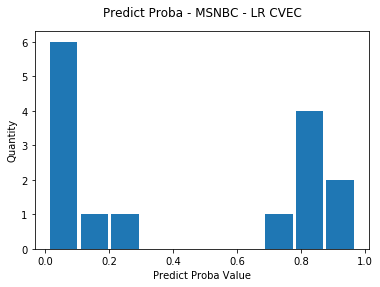

In [68]:
plt.hist(predict_lr_cvec_df['MSNBC'], rwidth = 0.9);

plt.title('Predict Proba - MSNBC - LR CVEC', pad = 15)
plt.xlabel('Predict Proba Value')
plt.ylabel('Quantity');

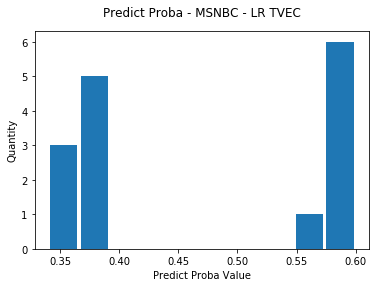

In [69]:
plt.hist(predict_lr_tvec_df['MSNBC'], rwidth = 0.9);

plt.title('Predict Proba - MSNBC - LR TVEC', pad = 15)
plt.xlabel('Predict Proba Value')
plt.ylabel('Quantity');

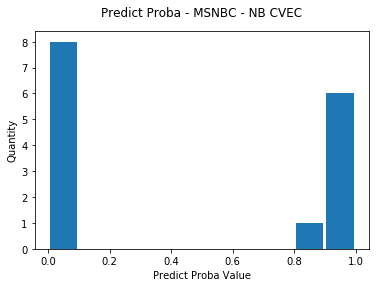

In [70]:
plt.hist(predict_mnb_cvec_df['MSNBC'], rwidth = 0.9);

plt.title('Predict Proba - MSNBC - NB CVEC', pad = 15)
plt.xlabel('Predict Proba Value')
plt.ylabel('Quantity');

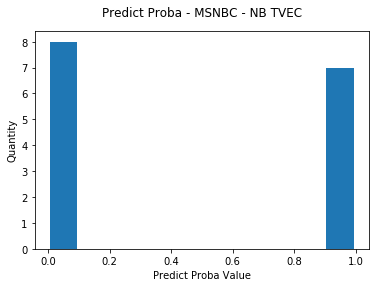

In [71]:
plt.hist(predict_gnb_tvec_df['MSNBC'], rwidth = 0.9);

plt.title('Predict Proba - MSNBC - NB TVEC', pad = 15)
plt.xlabel('Predict Proba Value')
plt.ylabel('Quantity');